# Mauna Loa time series example

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/1-mauna-loa/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/1-mauna-loa/).*

In this notebook, we apply Gaussian process regression to the Mauna Loa CO₂
dataset. This showcases a rich combination of kernels, and how to handle and
optimize all their parameters.

## Setup

We make use of the following packages:

In [1]:
using CSV, DataFrames  # data loading
using AbstractGPs  # exact GP regression
using ParameterHandling  # for nested and constrained parameters
using Optim  # optimization
using Zygote  # auto-diff gradient computation
using Plots  # visualisation

Let's load and visualize the dataset.

!!! tip
    The `let` block [creates a new
    scope](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#scope-of-variables),
    so any utility variables we define in here won't leak outside. This is
    particularly helpful to keep notebooks tidy! The return value of the
    block is given by its last expression.

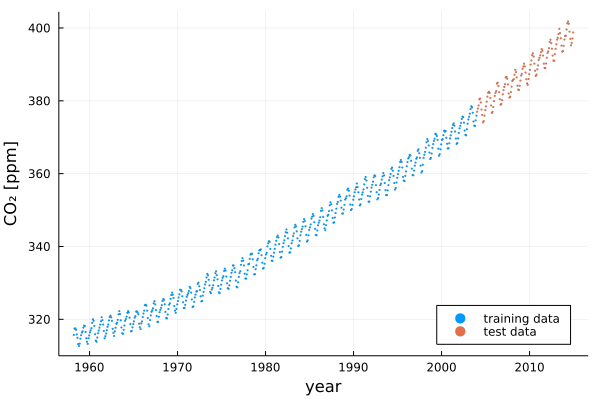

In [2]:
(xtrain, ytrain), (xtest, ytest) = let
    data = CSV.read(joinpath("/home/runner/work/AbstractGPs.jl/AbstractGPs.jl/examples/1-mauna-loa", "CO2_data.csv"), Tables.matrix; header=0)
    year = data[:, 1]
    co2 = data[:, 2]

    # We split the data into training and testing set:
    idx_train = year .< 2004
    idx_test = .!idx_train

    (year[idx_train], co2[idx_train]), (year[idx_test], co2[idx_test])  # block's return value
end
# The utility variables such as `idx_train` and `idx_test` are not available outside the `let` scope

function plotdata()
    plot(; xlabel="year", ylabel="CO₂ [ppm]", legend=:bottomright)
    scatter!(xtrain, ytrain; label="training data", ms=2, markerstrokewidth=0)
    return scatter!(xtest, ytest; label="test data", ms=2, markerstrokewidth=0)
end

plotdata()

## Prior

We will model this dataset using a sum of several kernels which describe

- smooth trend: squared exponential kernel with long lengthscale;
- seasonal component: periodic covariance function with period of one year,
  multiplied with a squared exponential kernel to allow decay away from exact
  periodicity;
- medium-term irregularities: rational quadratic kernel;
- noise terms: squared exponential kernel with short lengthscale
  and uncorrelated observation noise.

For more details, see [Rasmussen & Williams (2005), chapter 5](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

We will use
[ParameterHandling.jl](https://invenia.github.io/ParameterHandling.jl/) for
handling the (hyper)parameters of our model. It provides functions such as
`positive` with which we can put constraints on the hyperparameters, and
allows us to represent all required parameters as a nested NamedTuple:

In [3]:
# initial values to match http://stor-i.github.io/GaussianProcesses.jl/latest/mauna_loa/
θ_init = (;
    se_long = (;
        σ = positive(exp(4.0)),
        ℓ = positive(exp(4.0)),
    ),
    seasonal = (;
        # product kernels only need a single overall signal variance
        per = (;
            ℓ = positive(exp(0.0)),  # relative to period!
            p = fixed(1.0),  # 1 year, do not optimize over
        ),
        se = (;
            σ = positive(exp(1.0)),
            ℓ = positive(exp(4.0)),
        ),
    ),
    rq = (;
        σ = positive(exp(0.0)),
        ℓ = positive(exp(0.0)),
        α = positive(exp(-1.0)),
    ),
    se_short = (;
        σ = positive(exp(-2.0)),
        ℓ = positive(exp(-2.0)),
    ),
    noise_scale = positive(exp(-2.0)),
)

(se_long = (σ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.9999999997270757, exp, 1.4901161193847656e-8), ℓ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.9999999997270757, exp, 1.4901161193847656e-8)), seasonal = (per = (ℓ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.490116130486996e-8, exp, 1.4901161193847656e-8), p = ParameterHandling.Fixed{Float64}(1.0)), se = (σ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.9999999945181691, exp, 1.4901161193847656e-8), ℓ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.9999999997270757, exp, 1.4901161193847656e-8))), rq = (σ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.490116130486996e-8, exp, 1.4901161193847656e-8), ℓ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.490116130486996e-8, exp, 1.4901161193847656e-8), α = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.0000000405055565, exp, 1.4901161193847656e-8)), se_short = 

We define a couple of helper functions to simplify the kernel construction:

In [4]:
SE(θ) = θ.σ^2 * with_lengthscale(SqExponentialKernel(), θ.ℓ)
# PeriodicKernel is broken, see https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/issues/389
##Per(θ) = with_lengthscale(PeriodicKernel(; r=[θ.ℓ/2]), θ.p)  # NOTE- discrepancy with GaussianProcesses.jl
Per(θ) = with_lengthscale(SqExponentialKernel(), θ.ℓ) ∘ PeriodicTransform(1 / θ.p)
RQ(θ) = θ.σ^2 * with_lengthscale(RationalQuadraticKernel(; α=θ.α), θ.ℓ)

RQ (generic function with 1 method)

This allows us to write a function that, given the nested tuple of parameter values, constructs the GP prior:

In [5]:
function build_gp_prior(θ)
    k_smooth_trend = SE(θ.se_long)
    k_seasonality = Per(θ.seasonal.per) * SE(θ.seasonal.se)
    k_medium_term_irregularities = RQ(θ.rq)
    k_noise_terms = SE(θ.se_short) + θ.noise_scale^2 * WhiteKernel()
    kernel = k_smooth_trend + k_seasonality + k_medium_term_irregularities + k_noise_terms
    return GP(kernel)  # `ZeroMean` mean function by default
end

build_gp_prior (generic function with 1 method)

## Posterior

To construct the posterior, we need to first build a `FiniteGP`,
which represents the infinite-dimensional GP at a finite number of input
features:

In [6]:
function build_finite_gp(θ)
    f = build_gp_prior(θ)
    return f(xtrain)
end

build_finite_gp (generic function with 1 method)

!!! info "`WhiteKernel` vs `FiniteGP` observation noise"
    In this notebook, we already included observation noise through the
    `WhiteKernel` as part of the GP prior covariance in `build_gp_prior`. We
    therefore call `f(xtrain)` which implies zero (additional) observation
    noise.

    Alternatively, we could have omitted the `θ.noise_scale^2 *
    WhiteKernel()` term and instead passed the noise variance as a second
    argument to the GP call in `build_finite_gp`, `f(xtrain,
    θ.noise_scale^2)`.

    These two approaches have slightly different semantics: In the first one,
    the `WhiteKernel` contributes non-zero variance to the `[i, j]` element
    of the covariance matrix of the `FiniteGP` if `xtrain[i] == xtrain[j]`
    (based on the values of the features). In the second one, the observation
    noise variance passed to `FiniteGP` only contributes to the diagonal
    elements of the covariance matrix, i.e. for `i == j`.

    Moreover, the variance (uncertainty) of the posterior predictions
    includes the variance from the `WhiteKernel`, but does not include the
    variance of the observation noise passed to the `FiniteGP`. To include
    the observation noise in posterior predictions from the second approach,
    call `fpost_opt(xtest, noise_scale^2)`.

!!! tip
    For most use-cases and if in any doubt, we recommend that you pass in
    observation noise to the `FiniteGP`, and omit the explicit `WhiteKernel`.
    This is slightly faster (no need to check `xtrain[i] == xtrain[j]` for
    all pairs `i`, `j`), and `WhiteKernel` will not give stable gradients if
    you wish to compute the gradient of the log marginal likelihood
    `logpdf(f(x), y)` w.r.t. `x`.

We obtain the posterior, conditioned on the (finite) observations, by calling
`posterior`:

In [7]:
function build_posterior_gp(θ)
    fx = build_finite_gp(θ)
    return posterior(fx, ytrain)
end

build_posterior_gp (generic function with 1 method)

Now we can put it all together to obtain a `PosteriorGP`.
The call to `ParameterHandling.value` is required to replace the constraints
(such as `positive` in our case) with concrete numbers:

In [8]:
fpost_init = build_posterior_gp(ParameterHandling.value(θ_init))

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.KernelSum{Tuple{KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}, KernelFunctions.KernelProduct{Tuple{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ChainTransform{Vector{KernelFunctions.Transform}}}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}}}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.RationalQuadraticKernel{Float64, Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float

Let's visualize what the GP fitted to the data looks like, for the initial choice of kernel hyperparameters.

We use the following function to plot a GP `f` on a specific range, using the
AbstractGPs [plotting
recipes](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/concrete_features/#Plotting).
By setting `ribbon_scale=2` we visualize the uncertainty band with $\pm 2$
(instead of the default $\pm 1$) standard deviations.

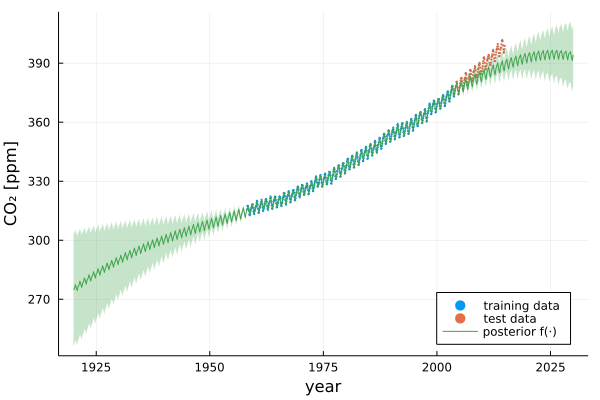

In [9]:
plot_gp!(f; label) = plot!(f(1920:0.2:2030); ribbon_scale=2, linewidth=1, label)

plotdata()
plot_gp!(fpost_init; label="posterior f(⋅)")

A reasonable fit to the data, but poor extrapolation away from the observations!

## Hyperparameter Optimization

To improve the fit, we want to maximize the (log) marginal likelihood with
respect to the hyperparameters.
[Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/) expects to
minimize a loss, so we define it as the negative log marginal likelihood:

In [10]:
function loss(θ)
    fx = build_finite_gp(θ)
    lml = logpdf(fx, ytrain)  # this computes the log marginal likelihood
    return -lml
end

loss (generic function with 1 method)

!!! note "Work-in-progress"
    In the future, we are planning to provide the `optimize_loss` utility
    function as part of JuliaGaussianProcesses -- for now, we just define it
    inline.

The L-BFGS parameters were chosen because they seem to work well empirically.
You could also try with the defaults.

In [11]:
default_optimizer = LBFGS(;
    alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
    linesearch=Optim.LineSearches.BackTracking(),
)

function optimize_loss(loss, θ_init; optimizer=default_optimizer, maxiter=1_000)
    options = Optim.Options(; iterations=maxiter, show_trace=true)

    θ_flat_init, unflatten = ParameterHandling.value_flatten(θ_init)
    loss_packed = loss ∘ unflatten

    # https://julianlsolvers.github.io/Optim.jl/stable/#user/tipsandtricks/#avoid-repeating-computations
    function fg!(F, G, x)
        if F !== nothing && G !== nothing
            val, grad = Zygote.withgradient(loss_packed, x)
            G .= only(grad)
            return val
        elseif G !== nothing
            grad = Zygote.gradient(loss_packed, x)
            G .= only(grad)
            return nothing
        elseif F !== nothing
            return loss_packed(x)
        end
    end

    result = optimize(Optim.only_fg!(fg!), θ_flat_init, optimizer, options; inplace=false)

    return unflatten(result.minimizer), result
end

optimize_loss (generic function with 1 method)

We now run the optimization:

In [12]:
θ_opt, opt_result = optimize_loss(loss, θ_init)
opt_result

Iter     Function value   Gradient norm 
     0     2.285662e+02     3.466984e+02
 * time: 7.891654968261719e-5
     1     1.597968e+02     5.811062e+01
 * time: 18.776474952697754
     2     1.516902e+02     4.934826e+01
 * time: 37.15150809288025
     3     1.311976e+02     4.436589e+01
 * time: 56.95258808135986
     4     1.250485e+02     2.431027e+01
 * time: 76.2931079864502
     5     1.208493e+02     7.951625e+00
 * time: 95.60301804542542
     6     1.190798e+02     9.556061e+00
 * time: 114.20814394950867
     7     1.172102e+02     7.308223e+00
 * time: 133.67518591880798
     8     1.161961e+02     5.340277e+00
 * time: 152.04005599021912
     9     1.157434e+02     2.651221e+00
 * time: 173.65522408485413
    10     1.156009e+02     1.236216e+00
 * time: 192.30425190925598
    11     1.155254e+02     7.740441e-01
 * time: 210.711040019989
    12     1.154963e+02     3.221268e-01
 * time: 230.81370306015015
    13     1.154897e+02     1.036321e+00
 * time: 249.0480329990387

 * Status: success

 * Candidate solution
    Final objective value:     1.152856e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.71e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   1298  (vs limit Inf)
    Iterations:    68
    f(x) calls:    94
    ∇f(x) calls:   68


The final value of the log marginal likelihood is:

In [13]:
-opt_result.minimum

-115.2855673720781

!!! warning
    To avoid bad local optima, we could (and should) have carried out several
    random restarts with different initial values for the hyperparameters,
    and then picked the result with the highest marginal likelihood. We omit
    this for simplicity. For more details on how to fit GPs in practice,
    check out [A Practical Guide to Gaussian
    Processes](https://tinyurl.com/guide2gp).

Let's construct the posterior GP with the optimized hyperparameters:

In [14]:
fpost_opt = build_posterior_gp(ParameterHandling.value(θ_opt))

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.KernelSum{Tuple{KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}, KernelFunctions.KernelProduct{Tuple{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ChainTransform{Vector{KernelFunctions.Transform}}}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}}}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.RationalQuadraticKernel{Float64, Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float

This is the kernel with the point-estimated hyperparameters:

In [15]:
fpost_opt.prior.kernel

Sum of 5 kernels:
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
			- Scale Transform (s = 0.006448897185857302)
			- σ² = 192280.44260931938
	Product of 2 kernels:
			Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
					- Chain of 2 transforms:
	 - Periodic Transform with frequency 1.0 |> Scale Transform (s = 0.6865795287425824)
			Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
					- Scale Transform (s = 0.01214045916278248)
					- σ² = 5.9848556345733135
	Rational Quadratic Kernel (α = 0.0004399161406727154, metric = Distances.Euclidean(0.0))
			- Scale Transform (s = 0.035623657659133875)
			- σ² = 301.08505533304464
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
			- Scale Transform (s = 8.756281496384778)
			- σ² = 0.028301426473287428
	White Kernel
			- σ² = 0.03576127401919166

Let's print the optimized values of the hyperparameters in a more helpful format:

!!! note "Work-in-progress"
    This is another utility function we would eventually like to move out of this notebook:

In [16]:
using Printf

show_params(nt::Union{Dict,NamedTuple}) = String(take!(show_params(IOBuffer(), nt)))
function show_params(io, nt::Union{Dict,NamedTuple}, indent::Int=0)
    for (s, v) in pairs(nt)
        if v isa Union{Dict,NamedTuple}
            println(io, " "^indent, s, ":")
            show_params(io, v, indent + 4)
        else
            println(io, " "^indent, s, " = ", @sprintf("%.3f", v))
        end
    end
    return io
end

print(show_params(ParameterHandling.value(θ_opt)))

se_long:
    σ = 438.498
    ℓ = 155.065
seasonal:
    per:
        ℓ = 1.456
        p = 1.000
    se:
        σ = 2.446
        ℓ = 82.369
rq:
    σ = 17.352
    ℓ = 28.071
    α = 0.000
se_short:
    σ = 0.168
    ℓ = 0.114
noise_scale = 0.189


And, finally, we can visualize our optimized posterior GP:

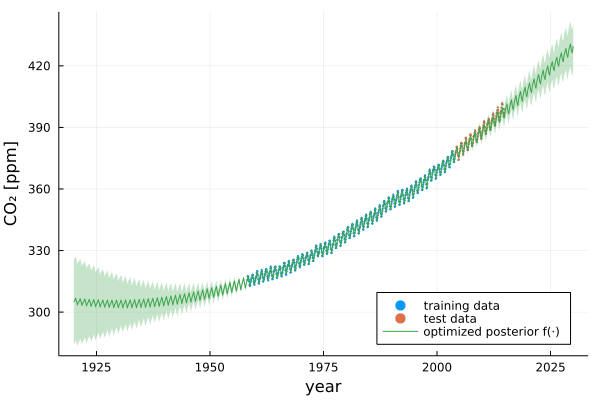

In [17]:
plotdata()
plot_gp!(fpost_opt; label="optimized posterior f(⋅)")

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
      Status &#96;~/work/AbstractGPs.jl/AbstractGPs.jl/examples/1-mauna-loa/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.13 &#96;/home/runner/work/AbstractGPs.jl/AbstractGPs.jl#448f826&#96;
  &#91;336ed68f&#93; CSV v0.10.4
  &#91;a93c6f00&#93; DataFrames v1.3.4
  &#91;98b081ad&#93; Literate v2.13.2
  &#91;429524aa&#93; Optim v1.7.0
  &#91;2412ca09&#93; ParameterHandling v0.4.2
  &#91;91a5bcdd&#93; Plots v1.29.0
  &#91;e88e6eb3&#93; Zygote v0.6.40
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.7.2
Commit bf53498635 &#40;2022-02-06 15:21 UTC&#41;
Platform Info:
  OS: Linux &#40;x86_64-pc-linux-gnu&#41;
  CPU: Intel&#40;R&#41; Xeon&#40;R&#41; Platinum 8171M CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 &#40;ORCJIT, skylake-avx512&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/fsJ6N/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*